# Определение перспективного тарифа для телеком-компании

Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов
Тариф «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 3 рубля
        сообщение: 3 рубля
        1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 1 рубль
        сообщение: 1 рубль
        1 Гб интернет-трафика: 150 рублей

## Изучение данных из файлов

### Импортируем планируемые к применению в проекте библиотеки

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st

### Открываем файлы

In [4]:
#открываем с учетом разделителя

calls = pd.read_csv('calls.csv', sep=',' , decimal='.')
internet = pd.read_csv('internet.csv', sep=',' , decimal='.')
messages = pd.read_csv('messages.csv', sep=',' , decimal='.')
tariffs = pd.read_csv('tariffs.csv', sep=',' , decimal='.')
users = pd.read_csv('users.csv', sep=',' , decimal='.')

### Изучаем уникальные значения и структуру таблиц

#### Таблица calls

Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок
    
 Нулями обозначены пропущенные звонки, поэтому их не нужно удалять. 

In [5]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [6]:
calls.sort_values(by='call_date')

,id,call_date,duration,user_id
180968,1453_160,2018-01-01,0.00,1453
181239,1453_431,2018-01-01,19.92,1453
76907,1193_169,2018-01-01,13.29,1193
181903,1453_1095,2018-01-01,5.63,1453
181106,1453_298,2018-01-01,15.25,1453
...,...,...,...,...
51898,1130_186,2018-12-31,14.36,1130
155006,1382_789,2018-12-31,9.26,1382
173182,1427_546,2018-12-31,0.32,1427
30050,1076_342,2018-12-31,0.33,1076


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [8]:
calls['duration'].describe().apply(lambda x: format(x, '.2f'))

count    202607.00
mean          6.76
std           5.84
min           0.00
25%           1.30
50%           6.00
75%          10.70
max          38.00
Name: duration, dtype: object

In [9]:
calls['user_id'].nunique()

492

<AxesSubplot:title={'center':'Распределение длительности звонков за 1 звонок'}, ylabel='Frequency'>

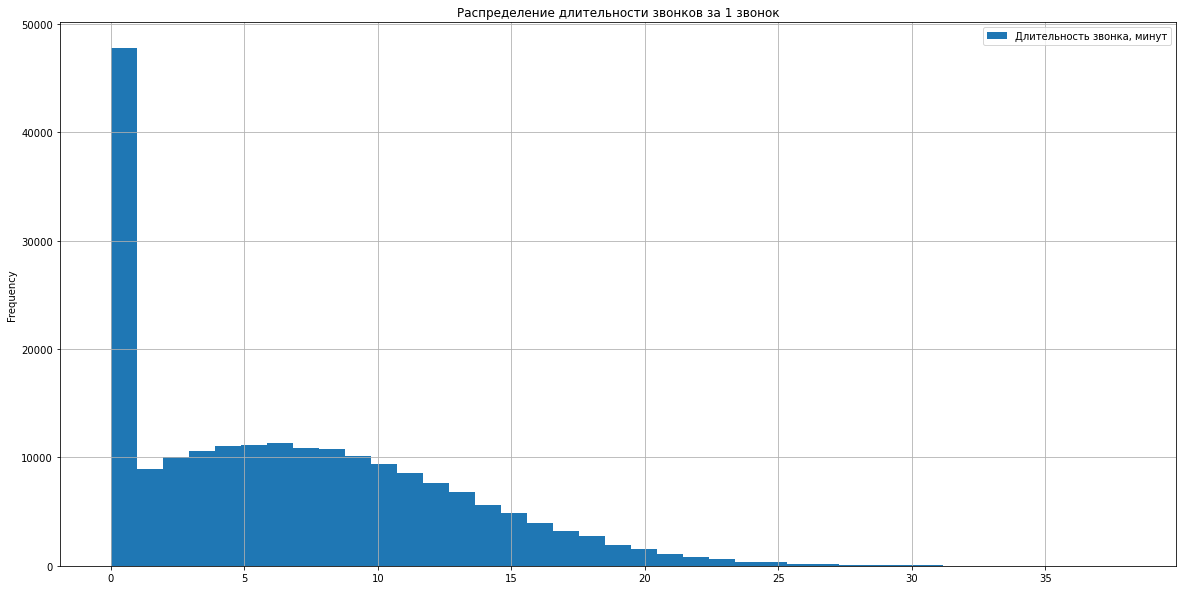

In [10]:
calls.plot(
    kind='hist',
    y='duration',
    figsize=[20,10],
    bins=39,
    linewidth=5,
    alpha=1,
    range=(0,38),
    label='Длительность звонка, минут',
    grid=True,
    legend=True,
    title='Распределение длительности звонков за 1 звонок'
)

<AxesSubplot:title={'center':'Распределение длительности звонков за 1 звонок'}, ylabel='Frequency'>

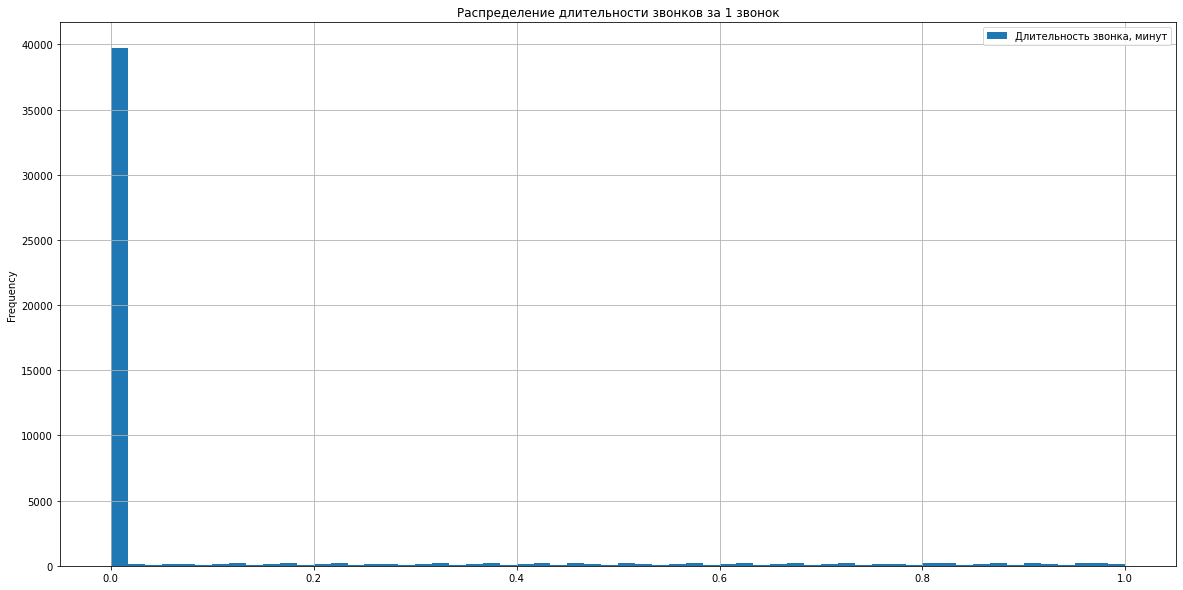

In [11]:
# Более детально изучим первую минуту звонка

calls.plot(
    kind='hist',
    y='duration',
    figsize=[20,10],
    bins=60,
    linewidth=5,
    alpha=1,
    range=(0,1),
    label='Длительность звонка, минут',
    grid=True,
    legend=True,
    title='Распределение длительности звонков за 1 звонок'
)

**Вывод**

- Столбец с датой - потребуется перевод в формат даты и выделение столбца с номером месяца;
- Количество пользователей, по которым есть данные о звонках - 492 из 500;
- Почти четверть звонков - пропущенные, если судить по 0 минутам;
- Дробная часть минуты приведена в сотых (тогда как в минуте 60 секунд), однако, с учетом того, что КАЖДЫЙ звонок округляется до минуты, это расхождение - не проблема;
- Пропуски в данных отсутствуют;
- Данные только за 2018 год - корректная выгрузка.

#### Таблица internet

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя
    
    Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
    
    1 гигабайт = 1024 мегабайта

In [12]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [14]:
internet.sort_values(by='session_date')

,Unnamed: 0,id,mb_used,session_date,user_id
135277,135277,1453_498,209.31,2018-01-01,1453
57584,57584,1193_123,0.00,2018-01-01,1193
135081,135081,1453_302,794.96,2018-01-01,1453
45314,45314,1155_501,0.00,2018-01-02,1155
16177,16177,1055_635,105.15,2018-01-02,1055
...,...,...,...,...,...
16943,16943,1058_119,563.07,2018-12-31,1058
146969,146969,1491_241,327.10,2018-12-31,1491
39896,39896,1141_18,337.04,2018-12-31,1141
90301,90301,1306_35,0.00,2018-12-31,1306


In [15]:
internet['mb_used'].describe().apply(lambda x: format(x, '.2f'))

count    149396.00
mean        370.19
std         278.30
min           0.00
25%         138.19
50%         348.01
75%         559.55
max        1724.83
Name: mb_used, dtype: object

In [16]:
internet['user_id'].nunique()

497

<AxesSubplot:title={'center':'Распределение потребления трафика за сессию'}, ylabel='Frequency'>

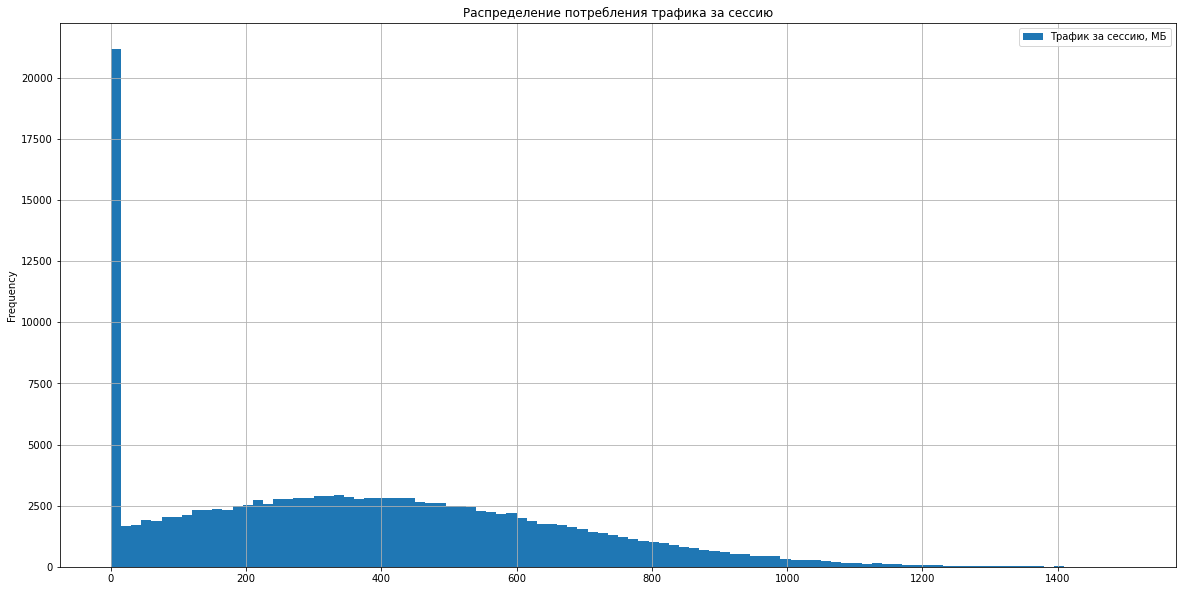

In [17]:
internet.plot(
    kind='hist',
    y='mb_used',
    figsize=[20,10],
    bins=100,
    linewidth=5,
    alpha=1,
    range=(0,1500),
    label='Трафик за сессию, МБ',
    grid=True,
    legend=True,
    title='Распределение потребления трафика за сессию'
)

<AxesSubplot:title={'center':'Распределение потребления трафика за сессию'}, ylabel='Frequency'>

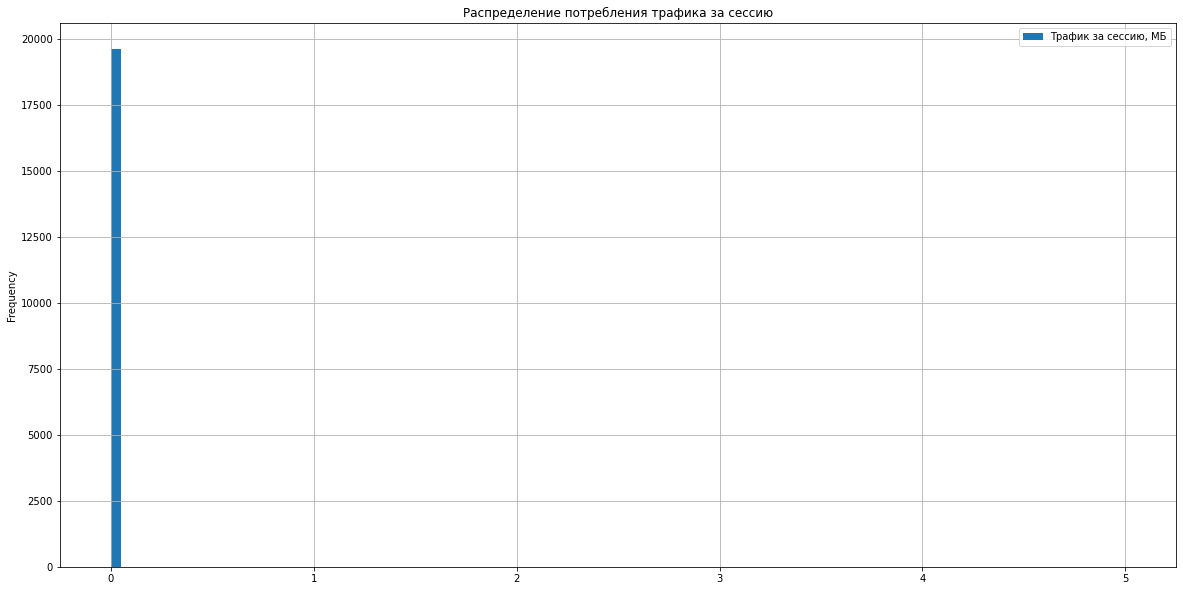

In [18]:
internet.plot(
    kind='hist',
    y='mb_used',
    figsize=[20,10],
    bins=100,
    linewidth=5,
    alpha=1,
    range=(0,5),
    label='Трафик за сессию, МБ',
    grid=True,
    legend=True,
    title='Распределение потребления трафика за сессию'
)

In [19]:
internet.query('mb_used == 0').count()[0]

19598

In [20]:
internet.query('mb_used < 1').count()[0]

19699

In [21]:
print((internet.query('mb_used == 0').count()[0]) / (internet.count()[0]))

0.13118155773916304


**Вывод**

- Столбец с датой - потребуется перевод в формат даты и выделение столбца с номером месяца;
- Количество пользователей, по которым есть данные об интернет сессиях - 497 из 500;
- Имеется лишний столбец unnamed, возможно ошибочно появился в выгрузке во время её формирования; 
- 13% от сессий - нулевые, при этом доля ненулевых сессий, но менее 1мб - минимальна, возможно появилась как техническая ошибка, либо как особенность учета: например клиент начал интернет сессию и тут же её прервал, не успев получить или передать данные, либо оператор сам блокировал передачу/прием данных, при инициализации интернет-сессии в роуминге. В любом случае, потребности удалять такие "нулевые" сессии нет, т.к. в итоге пойдет суммарный объем трафика за месяц по клиенту. 

#### Таблица messages

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

In [22]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [23]:
messages['user_id'].nunique()

426

In [24]:
messages.sort_values(by='message_date')

,id,message_date,user_id
35693,1155_82,2018-01-02,1155
112561,1453_586,2018-01-02,1453
112248,1453_273,2018-01-02,1453
36021,1155_410,2018-01-02,1155
13096,1055_62,2018-01-02,1055
...,...,...,...
52443,1231_1064,2018-12-31,1231
14184,1060_21,2018-12-31,1060
31402,1139_37,2018-12-31,1139
89442,1373_454,2018-12-31,1373


**Вывод**

- Столбец с датой - потребуется перевод в формат даты и выделение столбца с номером месяца;
- Количество пользователей, по которым есть данные о сообщениях - 426 из 500;

#### Таблица tariffs

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [25]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Вывод**

- Справочная таблица, какой либо предобработки не потребуется. 

#### Таблица users

Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tarif — название тарифного плана

In [26]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [27]:
users['age'].describe().apply(lambda x: format(x, '.0f'))

count    500
mean      47
std       17
min       18
25%       32
50%       46
75%       62
max       75
Name: age, dtype: object

In [28]:
users['user_id'].nunique()

500

<AxesSubplot:title={'center':'Распределение возраста клиентов'}, ylabel='Frequency'>

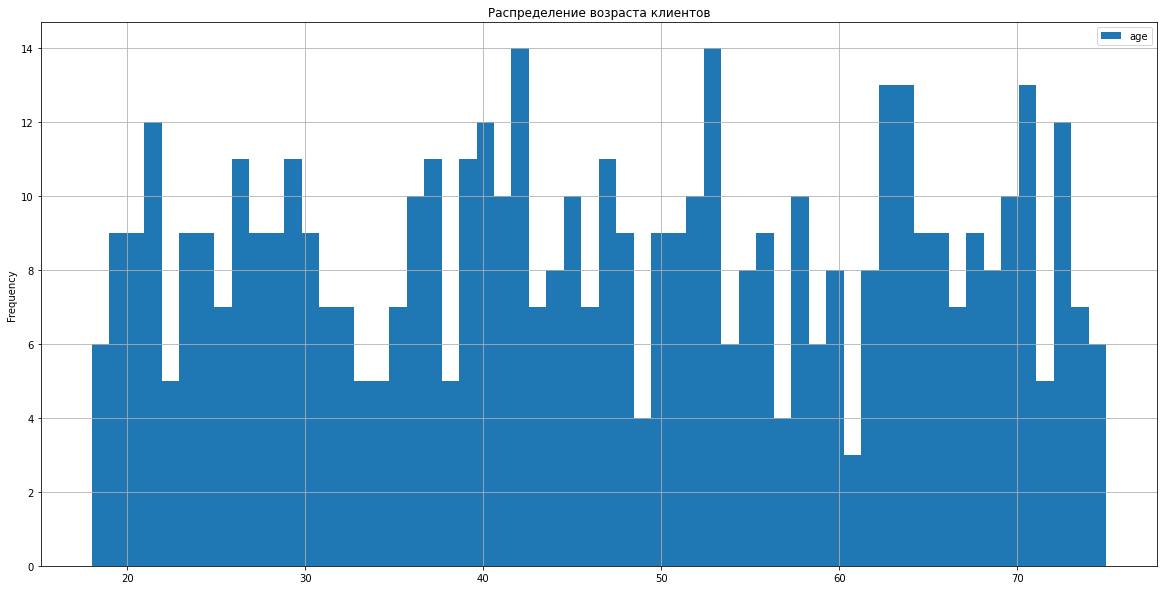

In [29]:
users.plot(
    kind='hist',
    y='age',
    figsize=[20,10],
    bins=58,
    linewidth=5,
    alpha=1,
    grid=True,
    legend=True,
    title='Распределение возраста клиентов'
)

In [30]:
users.query('city == "Москва"').count()[0]

99

In [31]:
print((users.query('city == "Москва"').count()[0]) / (users.count()[0]))

0.198


In [32]:
print((users.query('tariff == "ultra"').count()[0]) / (users.count()[0]))

0.298


**Вывод**

- Пользователей из Москвы - 20% от общего числа выборки;
- Распределение клиентов по тарифам - 30% Тариф Ультра, 70% Тариф Смарт;
- Для упрощения анализа по Москве/Региону потребуется создать допстолбец.

## Подготовка данных

-    Приведите данные к нужным типам;
-    Найдите и исправьте ошибки в данных, если они есть.

Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.
Посчитайте для каждого пользователя:

-    количество сделанных звонков и израсходованных минут разговора по месяцам;
-    количество отправленных сообщений по месяцам;
-    объем израсходованного интернет-трафика по месяцам;
-    помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

### Работа с таблицей users

Для дальнейше аналитической работы создадим новую таблицу users_new, в которой не будет лишней информации для задач текущего анализа. Нам понадобится - id клиента, его город в виде класса (1 - Мск, 0 - Не Мск) и тариф. Далее по тарифу мы объеденим таблицу с таблицу tariffs, чтобы в дальнейшем считать выручку по каждому направлению (звонки, интернет, смс) в своей сводной таблице и в конце вывести это в финальную аналитическую таблицу.

In [33]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [34]:
# Создаем функцию классификации локации клиента

def location(row):
    
    city = row['city']
    
    if city == 'Москва':
        return 1
    else:
        return 0

users['location'] = users.apply(location, axis=1)

In [35]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,location
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,1
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,0


In [36]:
#Получаем обезличенный датасет без лишней информации, 
# т.к. их возраст, имена и даты регистраций нас не интересуют.

users_short = users[['user_id', 'location', 'tariff']]
users_short.head(5)

,user_id,location,tariff
0,1000,0,ultra
1,1001,1,smart
2,1002,0,smart
3,1003,1,ultra
4,1004,0,ultra


In [37]:
#Сливаем 2 датасета для аналитических целей

users_new = users_short.merge(tariffs, left_on='tariff', right_on='tariff_name')
users_new = users_new.drop(['tariff_name'],axis=1).sort_values(by='user_id').reset_index(drop=True)
users_new.head(5)

,user_id,location,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,0,ultra,1000,30720,3000,1950,150,1,1
1,1001,1,smart,50,15360,500,550,200,3,3
2,1002,0,smart,50,15360,500,550,200,3,3
3,1003,1,ultra,1000,30720,3000,1950,150,1,1
4,1004,0,ultra,1000,30720,3000,1950,150,1,1


In [38]:
#Добавляем в users_short стимость тарифа (пригодится в будущем)

users_short = users_new[['user_id', 'location', 'tariff', 'rub_monthly_fee']]
users_short.head(5)

,user_id,location,tariff,rub_monthly_fee
0,1000,0,ultra,1950
1,1001,1,smart,550
2,1002,0,smart,550
3,1003,1,ultra,1950
4,1004,0,ultra,1950


### Работа с таблицей calls

In [39]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [40]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


**Шаг 1. Приведение даты к формату даты**

In [41]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')

In [42]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [43]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


**Шаг 2. Приведение каждого звонка к целому числу с округлением вверх (согласно политике учета звонков в компании)**

In [44]:
calls['duration_min'] = calls['duration'].apply(lambda x: math.ceil(x))

In [45]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            202607 non-null  object        
 1   call_date     202607 non-null  datetime64[ns]
 2   duration      202607 non-null  float64       
 3   user_id       202607 non-null  int64         
 4   duration_min  202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB


In [46]:
# Проверяем, что округление прошло в нужном нам формате

calls.head(15)

,id,call_date,duration,user_id,duration_min
0,1000_0,2018-07-25,0.00,1000,0
1,1000_1,2018-08-17,0.00,1000,0
2,1000_2,2018-06-11,2.85,1000,3
3,1000_3,2018-09-21,13.80,1000,14
4,1000_4,2018-12-15,5.18,1000,6
5,1000_5,2018-11-02,0.00,1000,0
6,1000_6,2018-10-18,0.00,1000,0
7,1000_7,2018-08-22,18.31,1000,19
8,1000_8,2018-09-15,18.44,1000,19
9,1000_9,2018-08-15,0.00,1000,0


**Шаг 3. Выделение месяца**

In [47]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head(5)

,id,call_date,duration,user_id,duration_min,month
0,1000_0,2018-07-25,0.00,1000,0,7
1,1000_1,2018-08-17,0.00,1000,0,8
2,1000_2,2018-06-11,2.85,1000,3,6
3,1000_3,2018-09-21,13.80,1000,14,9
4,1000_4,2018-12-15,5.18,1000,6,12


**Шаг 4. Создание сводной таблицы**

In [48]:
#Создаем сводную таблицу с группировкой по клиенту и месяцу, значения - сумма минут и количество звонков 
#(0 звонки тоже учитываем)

calls_pivot = calls.pivot_table(
index=['user_id', 'month'],
values='duration_min',
aggfunc=['count', 'sum'])

#Сбрасываем мультииндексы

calls_pivot = calls_pivot.reset_index()

#Переименовываем столбцы

calls_pivot.columns=['user_id', 'month', 'calls_count', 'calls_duration']

In [49]:
calls_pivot.head(10)

,user_id,month,calls_count,calls_duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
5,1000,10,57,350
6,1000,11,43,338
7,1000,12,46,333
8,1001,11,59,430
9,1001,12,63,414


Добавим в каждую строку количество минут, согласно тарифу, а также стоимость каждой минуты превышения тарифа для расчета затраченого лимита и выручки за звонки

In [50]:
calls_pivot = calls_pivot.merge(users_new, on='user_id',how='left')
calls_pivot = calls_pivot[['user_id', 'month', 'calls_count', 'calls_duration', 'minutes_included', 'rub_per_minute']]

In [51]:
calls_pivot.head(10)

,user_id,month,calls_count,calls_duration,minutes_included,rub_per_minute
0,1000,5,22,159,3000,1
1,1000,6,43,172,3000,1
2,1000,7,47,340,3000,1
3,1000,8,52,408,3000,1
4,1000,9,58,466,3000,1
5,1000,10,57,350,3000,1
6,1000,11,43,338,3000,1
7,1000,12,46,333,3000,1
8,1001,11,59,430,500,3
9,1001,12,63,414,500,3


In [52]:
#Рассчитаем выручку за превышение тарифа (если есть), в остальном случае = 0.

def calls_revenue(row):
    
    calls_duration = row['calls_duration']
    calls_limit = row['minutes_included']
    payment = row['rub_per_minute']
    
    if (calls_limit - calls_duration) >= 0:
        return 0
    else:
        return ((calls_duration - calls_limit) * payment)

calls_pivot['calls_revenue'] = calls_pivot.apply(calls_revenue, axis=1)

In [53]:
#Проверяем корректность расчетов

calls_pivot.query('calls_revenue > 0')

,user_id,month,calls_count,calls_duration,minutes_included,rub_per_minute,calls_revenue
32,1005,3,77,606,500,3,318
33,1005,4,101,712,500,3,636
34,1005,5,73,595,500,3,285
35,1005,6,80,612,500,3,336
36,1005,7,77,569,500,3,207
...,...,...,...,...,...,...,...
3158,1496,8,88,527,500,3,81
3161,1496,11,80,662,500,3,486
3162,1496,12,80,518,500,3,54
3165,1497,12,71,545,500,3,135


In [54]:
#Удаляем лишнюю для дальнейшего анализа информацию

calls_pivot = calls_pivot.drop(['minutes_included', 'rub_per_minute'],axis=1)
calls_pivot.head(5)

,user_id,month,calls_count,calls_duration,calls_revenue
0,1000,5,22,159,0
1,1000,6,43,172,0
2,1000,7,47,340,0
3,1000,8,52,408,0
4,1000,9,58,466,0


### Работа с таблицей internet

In [55]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [56]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


**Шаг 1. Приведение даты к формату даты**

In [57]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')

In [58]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [59]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


**Шаг 2. Выделение месяца**

In [60]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


**Шаг 3. Создание сводной таблицы**

In [61]:
#Создаем сводную таблицу с группировкой по клиенту и месяцу, значения - сумма потраченного трафика 

internet_pivot = internet.pivot_table(
index=['user_id', 'month'],
values='mb_used',
aggfunc='sum')

#Сбрасываем мультииндексы

internet_pivot = internet_pivot.reset_index()

internet_pivot['mb_used'] = internet_pivot['mb_used'].apply(lambda x: math.ceil(x))

In [62]:
internet_pivot.head(5)

,user_id,month,mb_used
0,1000,5,2254
1,1000,6,23234
2,1000,7,14004
3,1000,8,14056
4,1000,9,14569


In [63]:
internet_pivot = internet_pivot.merge(users_new, on='user_id',how='left')
internet_pivot = internet_pivot[['user_id', 'month', 'mb_used', 'mb_per_month_included', 'rub_per_gb']]

In [64]:
internet_pivot.head(10)

,user_id,month,mb_used,mb_per_month_included,rub_per_gb
0,1000,5,2254,30720,150
1,1000,6,23234,30720,150
2,1000,7,14004,30720,150
3,1000,8,14056,30720,150
4,1000,9,14569,30720,150
5,1000,10,14703,30720,150
6,1000,11,14757,30720,150
7,1000,12,9818,30720,150
8,1001,11,18430,15360,200
9,1001,12,14037,15360,200


Рассчитаем выручку за превышение, помня о том, что в 1Гб = 1024Мб и оператор округляет всегда вверх на уровне ГБ.

In [65]:
def internet_revenue(row):
    mb_used = row['mb_used']
    mb_limit = row['mb_per_month_included']
    payment = row['rub_per_gb']
    
    if (mb_limit - mb_used) >= 0:
        return 0
    else:
        return (math.ceil((mb_used - mb_limit) / 1024) * payment)

internet_pivot['internet_revenue'] = internet_pivot.apply(internet_revenue, axis=1)

In [66]:
internet_pivot.head(10)

,user_id,month,mb_used,mb_per_month_included,rub_per_gb,internet_revenue
0,1000,5,2254,30720,150,0
1,1000,6,23234,30720,150,0
2,1000,7,14004,30720,150,0
3,1000,8,14056,30720,150,0
4,1000,9,14569,30720,150,0
5,1000,10,14703,30720,150,0
6,1000,11,14757,30720,150,0
7,1000,12,9818,30720,150,0
8,1001,11,18430,15360,200,600
9,1001,12,14037,15360,200,0


In [67]:
#Проверяем корректность расчетов

internet_pivot.query('internet_revenue > 0')

,user_id,month,mb_used,mb_per_month_included,rub_per_gb,internet_revenue
8,1001,11,18430,15360,200,600
11,1002,7,17581,15360,200,600
12,1002,8,20320,15360,200,1000
13,1002,9,16692,15360,200,400
15,1002,11,18588,15360,200,800
...,...,...,...,...,...,...
3196,1498,8,24236,15360,200,1800
3197,1498,9,22135,15360,200,1400
3198,1498,10,20580,15360,200,1200
3200,1499,10,17789,15360,200,600


In [68]:
#Удаляем лишнюю для дальнейшего анализа информацию

internet_pivot = internet_pivot.drop(['mb_per_month_included', 'rub_per_gb'],axis=1)
internet_pivot.head(5)

,user_id,month,mb_used,internet_revenue
0,1000,5,2254,0
1,1000,6,23234,0
2,1000,7,14004,0
3,1000,8,14056,0
4,1000,9,14569,0


### Работа с таблицей messages

In [69]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [70]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


**Шаг 1. Приведение даты к формату даты**

In [71]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')

In [72]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB


**Шаг 2. Выделение месяца**

In [73]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head(5)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


**Шаг 3. Создание сводной таблицы**

In [74]:
#Создаем сводную таблицу с группировкой по клиенту и месяцу, значения - сумма потраченного трафика 

messages_pivot = messages.pivot_table(
index=['user_id', 'month'],
values='id',
aggfunc='count')

#Сбрасываем мультииндексы

messages_pivot = messages_pivot.reset_index()

#Переименовываем столбцы

messages_pivot.columns=['user_id', 'month', 'mess_count']

In [75]:
messages_pivot.head(5)

,user_id,month,mess_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [76]:
messages_pivot = messages_pivot.merge(users_new, on='user_id',how='left')
messages_pivot = messages_pivot[['user_id', 'month', 'mess_count', 'messages_included', 'rub_per_message']]

In [77]:
messages_pivot.head(10)

,user_id,month,mess_count,messages_included,rub_per_message
0,1000,5,22,1000,1
1,1000,6,60,1000,1
2,1000,7,75,1000,1
3,1000,8,81,1000,1
4,1000,9,57,1000,1
5,1000,10,73,1000,1
6,1000,11,58,1000,1
7,1000,12,70,1000,1
8,1002,6,4,50,3
9,1002,7,11,50,3


In [78]:
def messages_revenue(row):
    mess_count = row['mess_count']
    mess_limit = row['messages_included']
    payment = row['rub_per_message']
    
    if (mess_limit - mess_count) >= 0:
        return 0
    else:
        return ((mess_count - mess_limit) * payment)

messages_pivot['messages_revenue'] = messages_pivot.apply(messages_revenue, axis=1)

In [79]:
messages_pivot.head(10)

,user_id,month,mess_count,messages_included,rub_per_message,messages_revenue
0,1000,5,22,1000,1,0
1,1000,6,60,1000,1,0
2,1000,7,75,1000,1,0
3,1000,8,81,1000,1,0
4,1000,9,57,1000,1,0
5,1000,10,73,1000,1,0
6,1000,11,58,1000,1,0
7,1000,12,70,1000,1,0
8,1002,6,4,50,3,0
9,1002,7,11,50,3,0


In [80]:
#Проверяем корректность расчетов

messages_pivot.query('messages_revenue > 0')

,user_id,month,mess_count,messages_included,rub_per_message,messages_revenue
30,1005,3,56,50,3,18
34,1005,7,56,50,3,18
35,1005,8,64,50,3,42
36,1005,9,52,50,3,6
38,1005,11,51,50,3,3
...,...,...,...,...,...,...
2665,1490,7,62,50,3,36
2705,1496,12,51,50,3,3
2710,1498,8,62,50,3,36
2715,1499,11,59,50,3,27


In [81]:
#Удаляем лишнюю для дальнейшего анализа информацию

messages_pivot = messages_pivot.drop(['messages_included', 'rub_per_message'],axis=1)
messages_pivot.head(5)

,user_id,month,mess_count,messages_revenue
0,1000,5,22,0
1,1000,6,60,0
2,1000,7,75,0
3,1000,8,81,0
4,1000,9,57,0


### Финальная таблица

Итак, для финальной таблицы нам потребуются следующие датасеты:
- users_short - id клиента, его тариф, класс локации и абоненская плата в месяц;
- calls_pivot - id клиента, месяц, кол-во звонков, их длительность, выручка от превышения тарифа за звонки;
- internet_pivot - id клиента, месяц, потрачено МБ, выручка от превышения тарифа за интернет;
- messages_pivot - id клиента, месяц, отправлено СМС, выручка от превышения тарифа за СМС.

Соединим их в один сводный

#### Создание финальной сводной таблицы

In [82]:
final_table = calls_pivot.merge(internet_pivot,how='outer', left_on=['user_id','month'], right_on = ['user_id','month'])
final_table = final_table.merge(messages_pivot,how='outer', left_on=['user_id','month'], right_on = ['user_id','month'])
final_table = final_table.merge(users_short,how='left', on='user_id')

In [83]:
final_table.head(10)

,user_id,month,calls_count,calls_duration,calls_revenue,mb_used,internet_revenue,mess_count,messages_revenue,location,tariff,rub_monthly_fee
0,1000,5,22.0,159.0,0.0,2254.0,0.0,22.0,0.0,0,ultra,1950
1,1000,6,43.0,172.0,0.0,23234.0,0.0,60.0,0.0,0,ultra,1950
2,1000,7,47.0,340.0,0.0,14004.0,0.0,75.0,0.0,0,ultra,1950
3,1000,8,52.0,408.0,0.0,14056.0,0.0,81.0,0.0,0,ultra,1950
4,1000,9,58.0,466.0,0.0,14569.0,0.0,57.0,0.0,0,ultra,1950
5,1000,10,57.0,350.0,0.0,14703.0,0.0,73.0,0.0,0,ultra,1950
6,1000,11,43.0,338.0,0.0,14757.0,0.0,58.0,0.0,0,ultra,1950
7,1000,12,46.0,333.0,0.0,9818.0,0.0,70.0,0.0,0,ultra,1950
8,1001,11,59.0,430.0,0.0,18430.0,600.0,NaN,NaN,1,smart,550
9,1001,12,63.0,414.0,0.0,14037.0,0.0,NaN,NaN,1,smart,550


In [84]:
#Наводим порядок

final_table = final_table[['user_id', 'location', 'tariff', 'month', 'calls_count', 'calls_duration', 'mb_used', 'mess_count', 'rub_monthly_fee', 'calls_revenue', 'internet_revenue', 'messages_revenue']]
final_table = final_table.fillna(0)
final_table['calls_count'] = final_table['calls_count'].astype('int')
final_table['calls_duration'] = final_table['calls_duration'].astype('int')
final_table['mb_used'] = final_table['mb_used'].astype('int')
final_table['mess_count'] = final_table['mess_count'].astype('int')
final_table['calls_revenue'] = final_table['calls_revenue'].astype('int')
final_table['internet_revenue'] = final_table['internet_revenue'].astype('int')
final_table['messages_revenue'] = final_table['messages_revenue'].astype('int')
final_table

,user_id,location,tariff,month,calls_count,calls_duration,mb_used,mess_count,rub_monthly_fee,calls_revenue,internet_revenue,messages_revenue
0,1000,0,ultra,5,22,159,2254,22,1950,0,0,0
1,1000,0,ultra,6,43,172,23234,60,1950,0,0,0
2,1000,0,ultra,7,47,340,14004,75,1950,0,0,0
3,1000,0,ultra,8,52,408,14056,81,1950,0,0,0
4,1000,0,ultra,9,58,466,14569,57,1950,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,0,smart,8,0,0,11051,17,550,0,0,0
3210,1489,0,smart,9,0,0,17207,32,550,0,400,0
3211,1489,0,smart,10,0,0,19560,21,550,0,1000,0
3212,1489,0,smart,11,0,0,17492,20,550,0,600,0


**Пояснение**

Небольшое пояснение по заполнению пропусков 0. В данный датасет попали только активные клиенты хоть по 1 виду услуги, при этом по другой услуге у них отсутствуют данные (например звонки), что говорит о том, что клиент не пользовался звонками в этом месяце. 
Учитывать это в дальнейшем анализе стоит, а без заполнения 0 функции из статистических библиотек не произведут расчеты.

#### Расчет выручки по клиенту за месяц

In [85]:
final_table['month_revenue'] = final_table['rub_monthly_fee'] + final_table['calls_revenue'] + final_table['internet_revenue'] + final_table['messages_revenue']
final_table.head(10)

,user_id,location,tariff,month,calls_count,calls_duration,mb_used,mess_count,rub_monthly_fee,calls_revenue,internet_revenue,messages_revenue,month_revenue
0,1000,0,ultra,5,22,159,2254,22,1950,0,0,0,1950
1,1000,0,ultra,6,43,172,23234,60,1950,0,0,0,1950
2,1000,0,ultra,7,47,340,14004,75,1950,0,0,0,1950
3,1000,0,ultra,8,52,408,14056,81,1950,0,0,0,1950
4,1000,0,ultra,9,58,466,14569,57,1950,0,0,0,1950
5,1000,0,ultra,10,57,350,14703,73,1950,0,0,0,1950
6,1000,0,ultra,11,43,338,14757,58,1950,0,0,0,1950
7,1000,0,ultra,12,46,333,9818,70,1950,0,0,0,1950
8,1001,1,smart,11,59,430,18430,0,550,0,600,0,1150
9,1001,1,smart,12,63,414,14037,0,550,0,0,0,550


In [86]:
#Удаляем промежуточные столбцы
final_table = final_table.drop(['rub_monthly_fee', 'calls_revenue', 'internet_revenue', 'messages_revenue'],axis=1)

In [87]:
final_table.head(10)

,user_id,location,tariff,month,calls_count,calls_duration,mb_used,mess_count,month_revenue
0,1000,0,ultra,5,22,159,2254,22,1950
1,1000,0,ultra,6,43,172,23234,60,1950
2,1000,0,ultra,7,47,340,14004,75,1950
3,1000,0,ultra,8,52,408,14056,81,1950
4,1000,0,ultra,9,58,466,14569,57,1950
5,1000,0,ultra,10,57,350,14703,73,1950
6,1000,0,ultra,11,43,338,14757,58,1950
7,1000,0,ultra,12,46,333,9818,70,1950
8,1001,1,smart,11,59,430,18430,0,1150
9,1001,1,smart,12,63,414,14037,0,550


Выделим из финальной таблицы датасеты с каждым тарифом и с делением на Москву/регионы

In [88]:
final_table_ultra = final_table.query('tariff == "ultra"')
final_table_smart = final_table.query('tariff == "smart"')
final_table_msk = final_table.query('location == 1')
final_table_reg = final_table.query('location == 0')

Готово, можно переходить к следующему шагу. 

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки.

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

Посчитайте среднее количество, дисперсию и стандартное отклонение. 

Постройте гистограммы. 

Опишите распределения.

### Анализ минут разговора

#### Тариф Смарт

**Среднее и медиана**

In [89]:
print('Среднее значение =', '{:.0f}'.format(final_table_smart['calls_duration'].mean()))

Среднее значение = 418


Важно понимать, что в зависимости от постановки вопроса, потребуется либо убрать клиентов с нулевыми разговорами за месяц, либо их оставить. В случае, если постановка вопроса звучит как: какое среднее число минут тратят абоненты на звонки, то 0 разговоры мы оставляем, т.к. это такие же клиенты, которые лишь пользуются иными услугами компании (смс, интернет), и не заинтересованы в звонках.

Если же постановка вопроса звучит как: сколько в среднем требуется минут на звонки **для активных клиентов в сегменте звонков**, то нулевых клиентов по звонкам имеет смысл убрать. 

Однако, с учетом постановки вопроса в задаче: **Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?**, считаю, что в данном случае вариант оставить 0 клиентов в каждом сегменте будет более релеватно для оператора. 

In [90]:
print('Среднее значение при исключении нулевых клиентов =', '{:.0f}'.format(final_table_smart[final_table_smart['calls_duration'] > 0]['calls_duration'].mean()))

Среднее значение при исключении нулевых клиентов = 419


In [91]:
print('Медианное значение =', '{:.0f}'.format(final_table_smart['calls_duration'].median()))

Медианное значение = 422


**Дисперсия и стандартное отклонение**

In [92]:
#Считаем дисперсию с указанием параметра ddof=1, т.к. у нас выборка из общего числа клиентов.

print('Дисперсия =', '{:.0f}'.format(np.var(final_table_smart['calls_duration'], ddof=1)))

Дисперсия = 36219


In [93]:
print('Стандартное отклонение =', '{:.0f}'.format(np.sqrt(np.var(final_table_smart['calls_duration'], ddof=1))))

Стандартное отклонение = 190


In [94]:
#Верхняя граница, согласно правилу трех сигм (нижнюю исключаем, т.к. она равна 0 минутам)

print('{:.0f}'.format(final_table_smart['calls_duration'].mean() + np.sqrt(np.var(final_table_smart['calls_duration'], ddof=1)) * 3))

989


#### Тариф Ультра

**Среднее и медиана**

In [95]:
print('Среднее значение =', '{:.0f}'.format(final_table_ultra['calls_duration'].mean()))

Среднее значение = 527


In [96]:
print('Среднее значение при исключении нулевых клиентов =', '{:.0f}'.format(final_table_ultra[final_table_ultra['calls_duration'] > 0]['calls_duration'].mean()))

Среднее значение при исключении нулевых клиентов = 548


In [97]:
print('Медианное значение =', '{:.0f}'.format(final_table_ultra['calls_duration'].median()))

Медианное значение = 518


**Дисперсия и стандартное отклонение**

In [98]:
#Считаем дисперсию с указанием параметра ddof=1, т.к. у нас выборка из общего числа клиентов.

print('Дисперсия =', '{:.0f}'.format(np.var(final_table_ultra['calls_duration'], ddof=1)))

Дисперсия = 100874


In [99]:
print('Стандартное отклонение =', '{:.0f}'.format(np.sqrt(np.var(final_table_ultra['calls_duration'], ddof=1))))

Стандартное отклонение = 318


In [100]:
#Верхняя граница, согласно правилу трех сигм (нижнюю исключаем, т.к. она равна 0 минутам)

print('{:.0f}'.format(final_table_ultra['calls_duration'].mean() + np.sqrt(np.var(final_table_ultra['calls_duration'], ddof=1)) * 3))

1479


#### Общий вывод по минутам разговора

**График**

<AxesSubplot:title={'center':'Распределение длительности звонков в месяц, мин'}, ylabel='Frequency'>

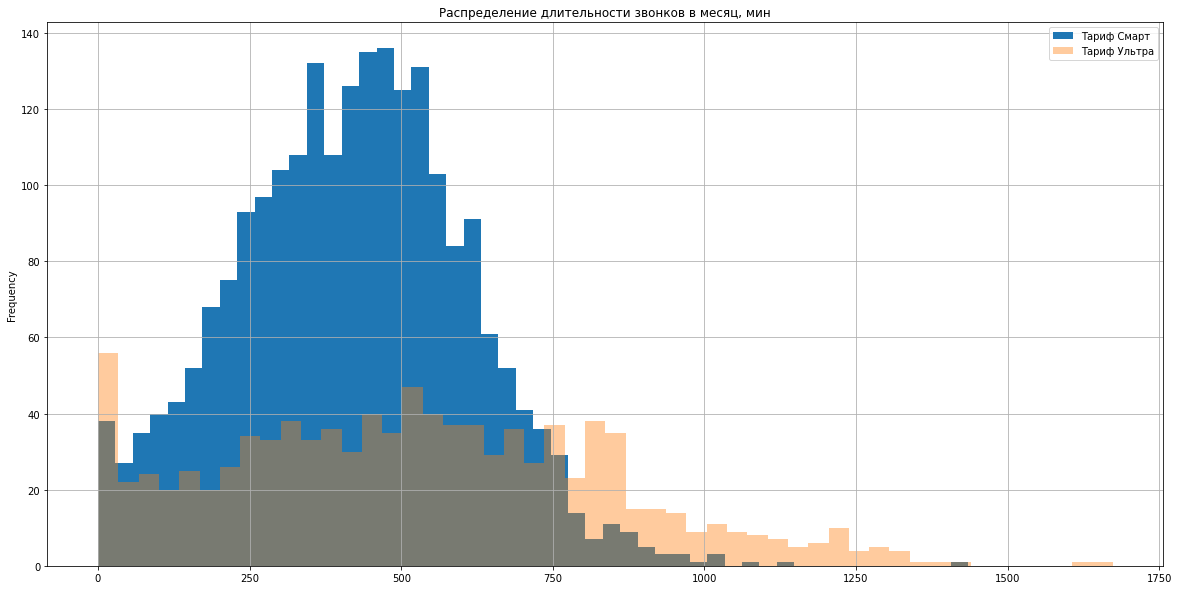

In [101]:
ax = final_table_smart.plot(
    kind='hist',
    y='calls_duration',
    figsize=[20,10],
    bins=50,
    linewidth=5,
    alpha=1,
    label='Тариф Смарт',
    grid=True,
    legend=True,
    title='Распределение длительности звонков в месяц, мин'
)

final_table_ultra.plot(
    kind='hist',
    y='calls_duration',
    figsize=[20,10],
    bins=50,
    linewidth=5,
    ax=ax,
    alpha=0.4,
    label='Тариф Ультра',
    grid=True,
    legend=True
)

In [102]:
print('{:.2%}'.format(len(final_table_smart.query('calls_duration > 500')) / len(final_table_smart)))
print('{:.2%}'.format(len(final_table_ultra.query('calls_duration > 1500')) / len(final_table_ultra)))

33.83%
0.20%


In [103]:
print('{:.2%}'.format(len(final_table_smart.query('calls_duration == 0')) / len(final_table_smart)))
print('{:.2%}'.format(len(final_table_ultra.query('calls_duration == 0')) / len(final_table_ultra)))

0.36%
3.86%


**Вывод**

Если средние значения минут звонков по обоим тарифам представлены примерно на одинаковом уровне 418 и 527 минут (с учетом разброса лимита минут по каждому тарифу в 500 и 3000 минут), то взглянув на график распределения можно заметить интересную особенность. 

Первая группа, тарифа Смарт, стремится средним значением к своему лимиту в 500 минут, хотя 34% клиентов превышают лимит в 500 минут. Распределение похоже на нормальное.

То вторая группа, тарифа Ультра по распределению напоминает равномерное. 
Для пользователей этого тарифа 3000 минут, более чем избыточны. И лишь 0.2% превышают в ежемесячных разговорах 1500 минут. 
Более того, если клиенты группы Смарт, очевидно, стараются контролировать свои разговоры (средняя стремится к лимиту), то клиенты группы Ультра не ограничивают себя и не контролируют в разговорах. А многие особо и не пользуются возможностью разговаривать без особых ограничений (из-за этого отсутствует характерный пик на среднем значении, как у Смарта, а также объем клиентов что в районе 200 минут, что в районе 700 примерно одинаковый). 

Эту теорию также подтверждает более высокая средняя у Ультра при более высоком стандартном отклонении. 
Также, объем пользователей с 0 минутами по тарифу Ультра более высокий, чем у Смарта.
Возможно тариф Ультра более популярный как корпоративно оплачиваемый, поэтому, в разрезе минут разговора, клиенты тарифа Ультра менее внимательны к своим финансам (подтвердим или опровергним это уже в 4 шаге в разделе подсчета средней выручки). 

Рассчитаем долю использования доступного лимита, в совокупном объеме, как сумма всех минут по звонкам, деленная на лимит на тариф умноженный на количество клиентов этого тарифа.
Если моя теория выше верна, то доля использования лимита звонков в тарифе Ультра должна быть значительно ниже. 

In [104]:
sum_limit_smart = len(final_table_smart) * 500
sum_limit_ultra = len(final_table_ultra) * 3000
sum_calls_smart = final_table_smart['calls_duration'].sum()
sum_calls_ultra = final_table_ultra['calls_duration'].sum()

print('{:.2%}'.format(sum_calls_smart / sum_limit_smart))
print('{:.2%}'.format(sum_calls_ultra / sum_limit_ultra))

83.59%
17.55%


Доля использования доступного лимита звонков в тарифе Смарт приближается к 84%, в свою очередь клиенты Ультра не используют доступные лимиты даже на одну пятую.

### Анализ кол-во сообщений

#### Тариф Смарт

**Среднее и медиана**

In [105]:
print('Среднее значение =', '{:.0f}'.format(final_table_smart['mess_count'].mean()))

Среднее значение = 33


In [106]:
print('Медианное значение =', '{:.0f}'.format(final_table_smart['mess_count'].median()))

Медианное значение = 28


**Дисперсия и стандартное отклонение**

In [107]:
#Считаем дисперсию с указанием параметра ddof=1, т.к. у нас выборка из общего числа клиентов.

print('Дисперсия =', '{:.0f}'.format(np.var(final_table_smart['mess_count'], ddof=1)))

Дисперсия = 797


In [108]:
print('Стандартное отклонение =', '{:.0f}'.format(np.sqrt(np.var(final_table_smart['mess_count'], ddof=1))))

Стандартное отклонение = 28


In [109]:
#Верхняя граница, согласно правилу трех сигм (нижнюю исключаем, т.к. она равна 0 СМС)

print('{:.0f}'.format(final_table_smart['mess_count'].mean() + np.sqrt(np.var(final_table_smart['mess_count'], ddof=1)) * 3))

118


#### Тариф Ультра

**Среднее и медиана**

In [110]:
print('Среднее значение =', '{:.0f}'.format(final_table_ultra['mess_count'].mean()))

Среднее значение = 49


In [111]:
print('Медианное значение =', '{:.0f}'.format(final_table_ultra['mess_count'].median()))

Медианное значение = 38


**Дисперсия и стандартное отклонение**

In [112]:
#Считаем дисперсию с указанием параметра ddof=1, т.к. у нас выборка из общего числа клиентов.

print('Дисперсия =', '{:.0f}'.format(np.var(final_table_ultra['mess_count'], ddof=1)))

Дисперсия = 2285


In [113]:
print('Стандартное отклонение =', '{:.0f}'.format(np.sqrt(np.var(final_table_ultra['mess_count'], ddof=1))))

Стандартное отклонение = 48


In [114]:
#Верхняя граница, согласно правилу трех сигм (нижнюю исключаем, т.к. она равна 0 СМС)

print('{:.0f}'.format(final_table_ultra['mess_count'].mean() + np.sqrt(np.var(final_table_ultra['mess_count'], ddof=1)) * 3))

193


#### Общий вывод по минутам разговора

**График**

<AxesSubplot:title={'center':'Распределение количества СМС в месяц'}, ylabel='Frequency'>

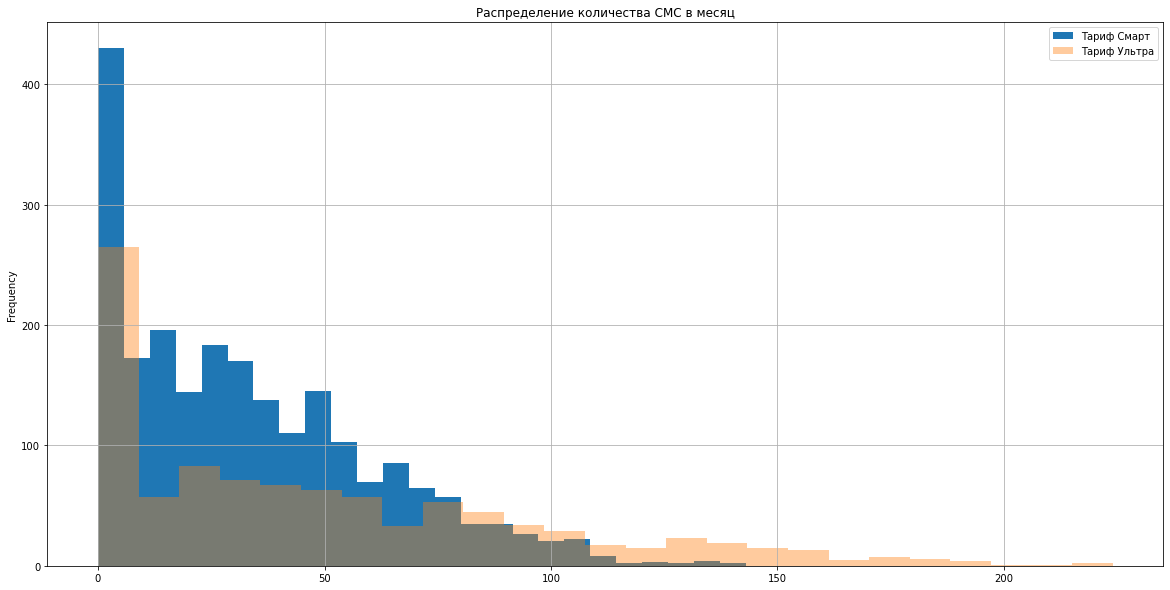

In [115]:
ax = final_table_smart.plot(
    kind='hist',
    y='mess_count',
    figsize=[20,10],
    bins=25,
    linewidth=5,
    alpha=1,
    label='Тариф Смарт',
    grid=True,
    legend=True,
    title='Распределение количества СМС в месяц'
)

final_table_ultra.plot(
    kind='hist',
    y='mess_count',
    figsize=[20,10],
    bins=25,
    linewidth=5,
    ax=ax,
    alpha=0.4,
    label='Тариф Ультра',
    grid=True,
    legend=True
)

In [116]:
print('{:.2%}'.format(len(final_table_smart.query('mess_count == 0')) / len(final_table_smart)))
print('{:.2%}'.format(len(final_table_ultra.query('mess_count == 0')) / len(final_table_ultra)))

13.77%
19.29%


**Вывод**

СМС сообщения наименее интересная клиента услуга у оператора. Если доля 0 звонков не превышает 4%, то СМС в том же тарифе Ультра не используют в 20% случаев.

Важно отметить, что распределения по графику выглядят одинаково и представляют собой Геометрическое распределение, где вероятность больших значений снижается. 
Однако распределение клиентов тарифа Ультра более плавное с длинным хвостом, что выражается в Стандартном отклонение, которое почти в 2 раза больше СО тарифа Смарт (48 против 28). 

Опять же, посчитаем по методике использованной в минутах, процент утилизации доступных лимитов по сообщениям.
Напомню, что для тарифа Смарт это 50 сообщений, для тарифа Ультра 1000.

In [117]:
sum_limit_smart = len(final_table_smart) * 50
sum_limit_ultra = len(final_table_ultra) * 1000
sum_calls_smart = final_table_smart['mess_count'].sum()
sum_calls_ultra = final_table_ultra['mess_count'].sum()

print('{:.2%}'.format(sum_calls_smart / sum_limit_smart))
print('{:.2%}'.format(sum_calls_ultra / sum_limit_ultra))

66.77%
4.94%


Ситуация аналогична минутам на разговоры. Использование доступного лимита СМС в тарифе Ультра минимальное, СМС в смарте более близки к максимальному бесплатному лимиту. 

### Анализ интернет трафика

#### Тариф Смарт

**Среднее и медиана**

In [118]:
print('Среднее значение =', '{:.0f}'.format(final_table_smart['mb_used'].mean()))

Среднее значение = 16209


In [119]:
print('Медианное значение =', '{:.0f}'.format(final_table_smart['mb_used'].median()))

Медианное значение = 16507


**Дисперсия и стандартное отклонение**

In [120]:
#Считаем дисперсию с указанием параметра ddof=1, т.к. у нас выборка из общего числа клиентов.

print('Дисперсия =', '{:.0f}'.format(np.var(final_table_smart['mb_used'], ddof=1)))

Дисперсия = 34462559


In [121]:
print('Стандартное отклонение =', '{:.0f}'.format(np.sqrt(np.var(final_table_smart['mb_used'], ddof=1))))

Стандартное отклонение = 5870


In [122]:
#Верхняя граница, согласно правилу трех сигм (нижнюю исключаем, т.к. она равна 0 Мб)

print('{:.0f}'.format(final_table_smart['mb_used'].mean() + np.sqrt(np.var(final_table_smart['mb_used'], ddof=1)) * 3))

33820


#### Тариф Ультра

**Среднее и медиана**

In [123]:
print('Среднее значение =', '{:.0f}'.format(final_table_ultra['mb_used'].mean()))

Среднее значение = 19469


In [124]:
print('Медианное значение =', '{:.0f}'.format(final_table_ultra['mb_used'].median()))

Медианное значение = 19309


**Дисперсия и стандартное отклонение**

In [125]:
#Считаем дисперсию с указанием параметра ddof=1, т.к. у нас выборка из общего числа клиентов.

print('Дисперсия =', '{:.0f}'.format(np.var(final_table_ultra['mb_used'], ddof=1)))

Дисперсия = 101751410


In [126]:
print('Стандартное отклонение =', '{:.0f}'.format(np.sqrt(np.var(final_table_ultra['mb_used'], ddof=1))))

Стандартное отклонение = 10087


In [127]:
#Верхняя граница, согласно правилу трех сигм (нижнюю исключаем, т.к. она равна 0 СМС)

print('{:.0f}'.format(final_table_ultra['mb_used'].mean() + np.sqrt(np.var(final_table_ultra['mb_used'], ddof=1)) * 3))

49731


#### Общий вывод по интернет трафику

**График**

<AxesSubplot:title={'center':'Распределение интернет трафика месяц'}, ylabel='Frequency'>

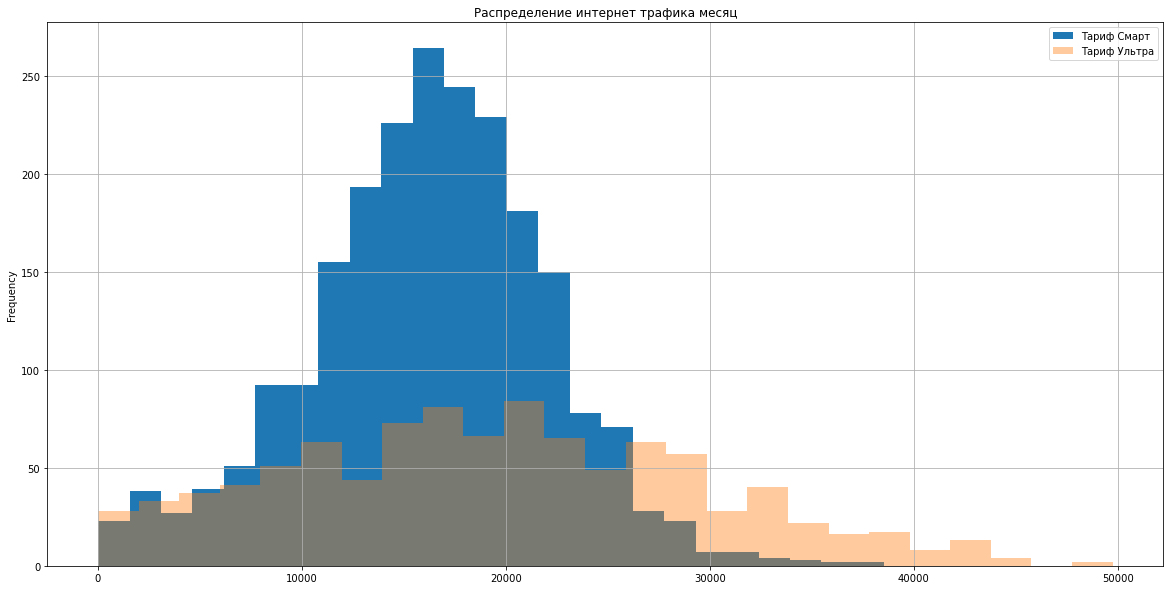

In [128]:
ax = final_table_smart.plot(
    kind='hist',
    y='mb_used',
    figsize=[20,10],
    bins=25,
    linewidth=5,
    alpha=1,
    label='Тариф Смарт',
    grid=True,
    legend=True,
    title='Распределение интернет трафика месяц'
)

final_table_ultra.plot(
    kind='hist',
    y='mb_used',
    figsize=[20,10],
    bins=25,
    linewidth=5,
    ax=ax,
    alpha=0.4,
    label='Тариф Ультра',
    grid=True,
    legend=True
)

In [129]:
print('{:.2%}'.format(len(final_table_smart.query('mb_used == 0')) / len(final_table_smart)))
print('{:.2%}'.format(len(final_table_ultra.query('mb_used == 0')) / len(final_table_ultra)))

0.09%
1.12%


**Вывод**

Ситуация в части 0 значений схожа со звонками, при этом в части популярности услуга интернета самая популярная в тройке звонки, смс, интернет, что, в целом, логично с учетом современных реалий использования смартфонов. При этом нельзя забывать, что возможны звонки также и через мобильные мессенджеры, однако через интернет трафик. Поэтому делать вывод в целом, что клиенты меньше любят разговаривать голосом - преждвременно.

Распределения по обоим тарифам является нормальным, при этом в части стандартного распределения картина схожа со звонками, в тарифе Ультра оно в 2 раза выше, что "размазывает" график по всей плоскости, хотя общий паттерн нормального распределения все еще сохраняется.

Также интересно отметить, что среднее значение в тарифе Смарт превышает максимальный лимит (среднее = 16209Мб, тогда как бесплатный лимит составляет 15Гб или 15360Мб). В свою очередь среднее по тарифу Ультра в 19469Мб не даёт такого прироста к средней, как прирост лимита от тарифа (30Гб)).

In [130]:
sum_limit_smart = len(final_table_smart) * 15360
sum_limit_ultra = len(final_table_ultra) * 30720
sum_calls_smart = final_table_smart['mb_used'].sum()
sum_calls_ultra = final_table_ultra['mb_used'].sum()

print('{:.2%}'.format(sum_calls_smart / sum_limit_smart))
print('{:.2%}'.format(sum_calls_ultra / sum_limit_ultra))

105.53%
63.38%


В подтверждение - общая утилизация доступных МБ по тарифам. По тарифу Смарт превышение лимита на 5,5%, по тарифу Ультра опять значительное отставание, хотя ситуация по использованию лимита и лучше, чем по другим продуктам. 

### Общая картина по клиентам

**Средний клиент оператора**

- активный пользователь интернета;
- мало использует СМС сообщения;
- скорее всего часть пользователей тарифа Ультра не платят за него самостоятельно, либо не считают для себя это значительной тратой, т.к. для многих было бы выгоднее использовать тариф Смарт с учетом их аппетитов по звонкам и СМС, доплачивая за превышение интернет трафика. 
- пользователи тарифа Смарт более внимательно подходят к использованию лимитов и в среднем стараются использовать значения максимально близкие к доступным им лимитам (по звонкам и интернету), при этом часть из них регулярно превышает интернет трафик и доплачивает за дополнительные ГБ.

## Проверка гипотез

Проверьте гипотезы

-    средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
-    средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение alpha задайте самостоятельно.
Поясните:

-    как вы формулировали нулевую и альтернативную гипотезы;
-    какой критерий использовали для проверки гипотез и почему.

### Гипотеза о различии средней выручки тарифов Ультра и Смарт

В рамках постановки гипотез пойдем от обратного, то есть равенства среднего двух выборок.

Постановка гипотезы:

Н0 - средняя выручка пользователей тарифа Смарт РАВНА средней выручки пользователей тарифа Ультра;

Н1 - средняя выручка пользователей тарифа Смарт НЕ РАВНА средней выручки пользователей тарифа Ультра;

В данном случае альтернативная гипотеза - двусторонняя. 

Потребуется использовать функцию st.ttest_ind для проверки гипотезы о неравенстве среднего двух генеральных совокупностей по взятым из них выборкам.

In [131]:
revenue_smart = final_table_smart['month_revenue']
revenue_ultra = final_table_ultra['month_revenue']

In [132]:
np.var(revenue_smart)

669485.2209234155

In [133]:
np.var(revenue_ultra)

141373.07325620213

In [134]:
alpha = 0.05

#используем опцию equal_var=False ввиду значительного различия дисперсий выборок

results = st.ttest_ind(revenue_smart, revenue_ultra, equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Таким образом гипотеза о РАВЕНСТВЕ средних двух выборок ОТВЕРГАЕТСЯ. Возможно утверждать, что средняя выручка двух тарифов РАЗЛИЧАЕТСЯ. 

In [135]:
revenue_smart.mean()

1289.9735307312696

In [136]:
revenue_ultra.mean()

2070.1522842639592

In [137]:
revenue_ultra.mean() / revenue_smart.mean()

1.6048021412427091

В абсолютном выражении средняя выручка тарифа Ультра в 1.6 раза больше средней выручки тарифа Смарт.

### Гипотеза о различии средней выручки клиентов из Москвы и регионов

Постановка гипотезы:

Н0 - средняя выручка пользователей из Москвы РАВНА средней выручки пользователей из регионов;

Н1 - средняя выручка пользователей из Москвы НЕ РАВНА средней выручки пользователей из регионов;

В данном случае альтернативная гипотеза - двусторонняя. 

Потребуется использовать функцию st.ttest_ind для проверки гипотезы о неравенстве среднего двух генеральных совокупностей по взятым из них выборкам.

In [138]:
revenue_msk = final_table_msk['month_revenue']
revenue_reg = final_table_reg['month_revenue']

In [139]:
np.var(revenue_msk)

564710.7117467269

In [140]:
np.var(revenue_reg)

653886.3270894106

In [141]:
results = st.ttest_ind(revenue_msk, revenue_reg)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Таким образом гипотеза о РАВЕНСТВЕ средних двух выборок НЕ ОТВЕРГАЕТСЯ. Возможно утверждать, что средняя выручка клиентов из Москвы и Регионов не различаются.

Вероятность получить среднюю в выручке из Москвы по сравнению с регионом равными или еще дальше друг от друга = 54%.

In [142]:
revenue_msk.mean()

1546.7135842880523

In [143]:
revenue_reg.mean()

1524.9362274298885

In [144]:
revenue_msk.mean() / revenue_reg.mean()

1.0142808312022773

В абсолютном выражении средняя выручка клиентов из Москвы отличается на 1,4% от средней выручки клиентов из Регионов. 

## Общий вывод

В рамках корректировки рекламного бюджета следует обратить внимание на удержание и продвижение тарифа Ультра, ввиду того, что он приносит на 60% средней выручки больше. 

При этом также желательно обратить внимание на использование лимитов в тарифе Ультра (максимальная утилизация только по интернет трафику порядка 60% от лимита), по остальным направлениям значительно ниже. 
Возможно, в рамках рекламной заманухи можно в тарифе Ультра установить безлимит по СМС и звонкам.

Также стоит обратить внимание на стабильное превышение включенного в пакет тарифа Смарт интернет трафика. Возможно предложить клиентам заранее повысить свой лимит на месяц не пакетами по 1гб, а по 3-5. С учетом превышения в среднем на 1-2Гб выше лимита, предложить такую цену, которая окажется более выгодной, чем если клиент будет платить за превышение в 1-2Гб, чем сразу себе покупать тариф Смарт + 5Гб. 